This code creates and stores a single model ensemble created from a selection of models. We used a customized CNN, and pretrained models including VGG19, InceptionResnetV2 and SqueezeNet, with their ImageNet weights initialized and fine-tuned end-to-end. The optimal model ensemble is chosen and saved to make further predictions. Five fold cross validation is performed on a patient-specific case.

In [2]:
#load libraries
#import gpu_imports
import keras
from keras.models import Model, Input
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Average, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras_squeezenet import SqueezeNet
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
import itertools
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras import applications
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
%matplotlib inline

Using TensorFlow backend.


In [3]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [4]:
#%% Loading the data

img_width, img_height = 128, 128
train_data_dir = 'malaria100/train'
validation_data_dir = 'malaria100/test'
epochs = 60
batch_size = 16 
num_classes= 2

# Since the models work with the data of the same shape, we 
#define a single input layer that will be used by every model.

input_shape = (128,128,3)
model_input = Input(shape=input_shape)
print(model_input) 

Tensor("input_1:0", shape=(None, 128, 128, 3), dtype=float32)


In [5]:
#%% declaring image data generators

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=2,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(128,128),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(128,128),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

Found 21258 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


In [6]:
#%% assign class weights to balance model training and penalize over-represented classes

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1.00463138 0.99541113]


Model: "custom_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      2

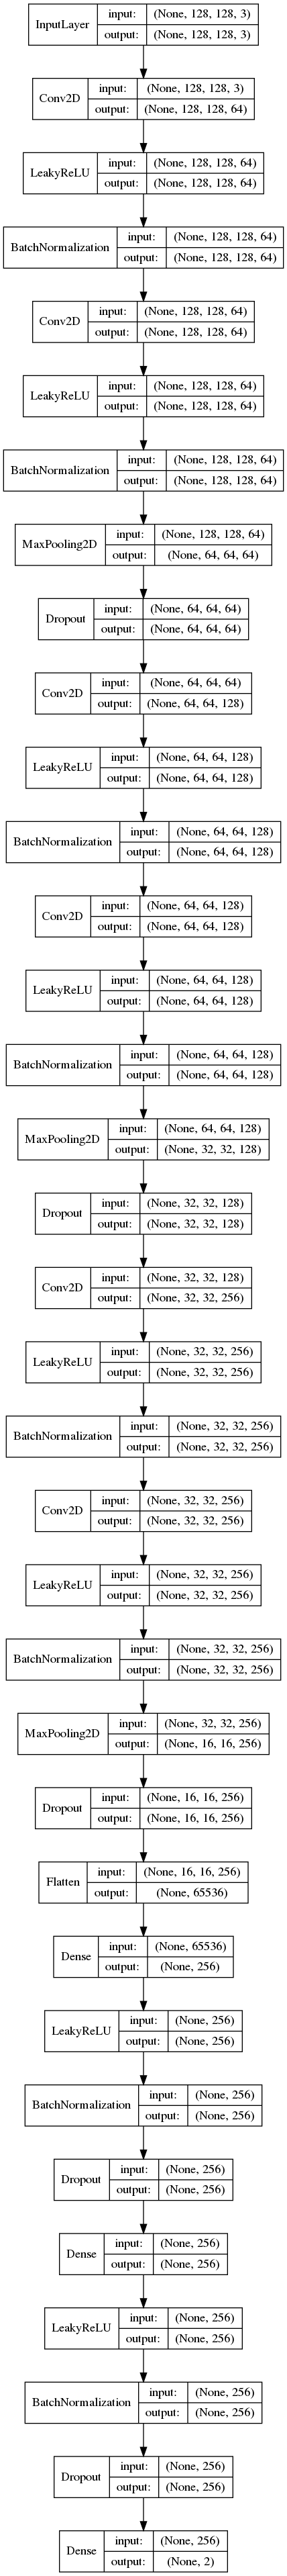

In [7]:
#%% define custom model and instantiate it
from keras.layers import LeakyReLU
from keras.layers import Flatten
leaky_relu_alpha = 0.1

def custom_cnn(model_input):
    x = Conv2D(64, (3,3), padding='same')(model_input)
    x = LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(256, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(256, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(256)(x)
    x = LeakyReLU(alpha=leaky_relu_alpha)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=model_input, outputs=x, name='custom_cnn')
    return model

#instantiate the model
custom_model = custom_cnn(model_input)

#display model summary
custom_model.summary()

#plot the model
plot_model(custom_model, to_file='custom_model_Leaky.png',show_shapes=True, show_layer_names=False)


Model: "vgg19_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

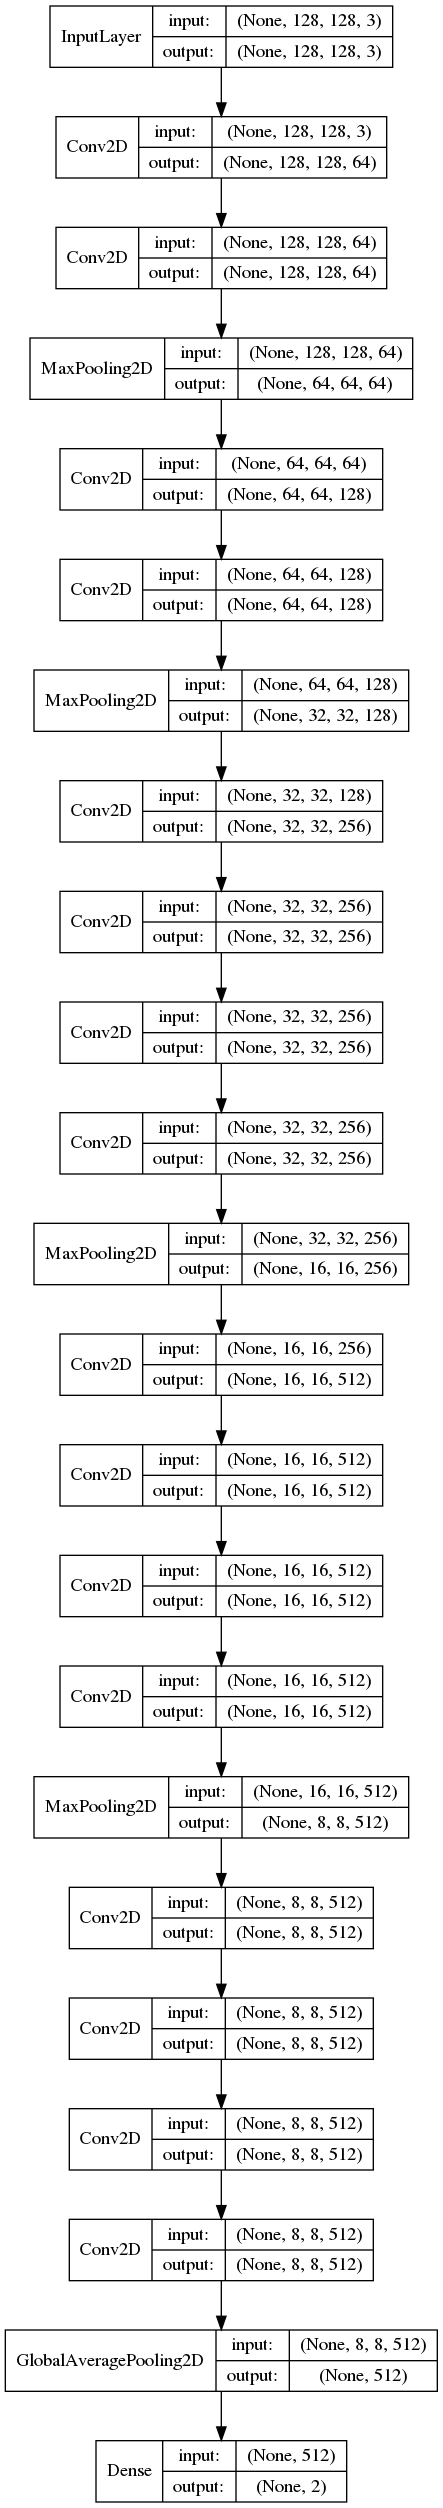

In [8]:
#%% VGG19 model 

def vgg19_cnn(model_input):
    vgg19_cnn = VGG19(weights='imagenet', include_top=False, input_tensor=model_input)
    x = vgg19_cnn.layers[-2].output 
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg19_cnn.input, outputs=predictions, name='vgg19_custom')
    return model

#instantiate the model
vgg19_custom_model = vgg19_cnn(model_input)

#plot model summary
vgg19_custom_model.summary()
plot_model(vgg19_custom_model, to_file='vgg19_custom_model.png',show_shapes=True, show_layer_names=False)


3039232/3032184 [==============================] - 13s 4us/step
Model: "squeeze_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
_____________________

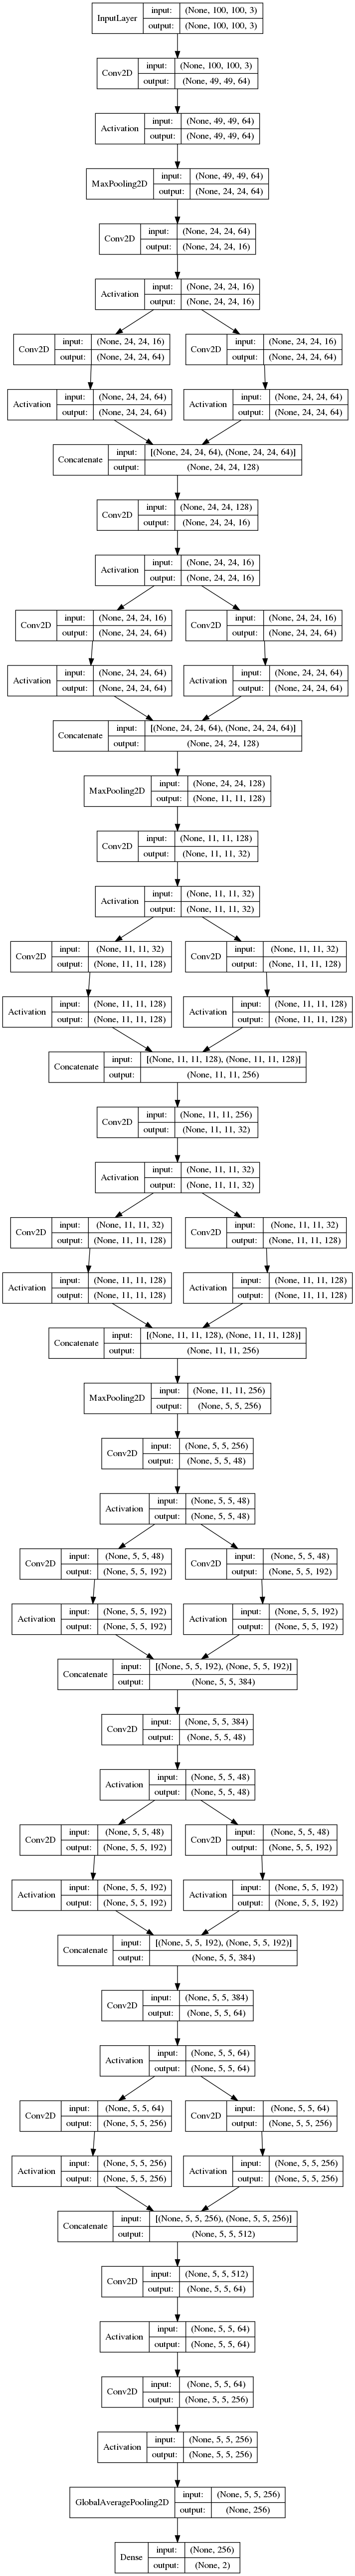

In [15]:
#%% SqueezeNet 

def squeeze_cnn(model_input):
    squeeze_cnn = SqueezeNet(weights='imagenet', include_top=False, input_tensor=model_input)
    x = squeeze_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=squeeze_cnn.input, outputs=predictions, name='squeeze_custom')
    return model

#instantiate the model
squeeze_custom_model = squeeze_cnn(model_input)

#display model summary
squeeze_custom_model.summary()

#plot model
plot_model(squeeze_custom_model, to_file='squeeze_custom_model.png',show_shapes=True, show_layer_names=False)


In [16]:
#%% Inception ResnetV2 

def incepres_cnn(model_input):
    incepres_cnn = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=model_input)
    x = incepres_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=incepres_cnn.input, outputs=predictions, name='InceptionResnet_custom')
    return model

#instantiate the model
inceptionresnet_custom_model = incepres_cnn(model_input)

#display model summary
inceptionresnet_custom_model.summary()

#plot model
plot_model(inceptionresnet_custom_model, to_file='inceptionresnet_custom_model.png',show_shapes=True, show_layer_names=False)


219062272/219055592 [==============================] - 146s 1us/step
Model: "InceptionResnet_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 49, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 49, 49, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 49, 32)   0           batch_normalization_2[0][0]      
________

In [9]:
#%% compile and train the custom model
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

adam = Adam(lr=0.001, decay = 0.001 / 64)  
custom_model.compile(optimizer=adam, 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy']) 
filepath = 'weights/' + custom_model.name + '.{epoch:02d}-{val_accuracy:.4f}.h5'

checkpoint = ModelCheckpoint('Leaky.h5', 
                             monitor = 'val_loss',  
                             mode = 'min',
                             save_weights_only = False, 
                             save_best_only = True,                              
                             verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss',
                         min_delta = 0.01,
                         patience = 15,
                         verbose = 1,
                         restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.01, 
                              patience=20,
                              verbose=1, 
                              min_lr=0.00001)

callbacks = [checkpoint, earlystop, reduce_lr]
#tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
# callbacks_list = [checkpoint, reduce_lr]
history = custom_model.fit_generator(train_generator, 
                                     steps_per_epoch=nb_train_samples // batch_size,
                                     epochs=epochs, validation_data=validation_generator,
                                     class_weight = class_weights,
                                     callbacks=callbacks, 
                                     validation_steps=nb_validation_samples // batch_size, 
                                     verbose=1) 


Epoch 1/60
1328/1328 [==============================] - 2623s 2s/step - loss: 0.3382 - accuracy: 0.8751 - val_loss: 0.4958 - val_accuracy: 0.9233

Epoch 00001: val_loss improved from inf to 0.49584, saving model to Leaky.h5
Epoch 2/60
1328/1328 [==============================] - 2274s 2s/step - loss: 0.2542 - accuracy: 0.9154 - val_loss: 0.6563 - val_accuracy: 0.9192

Epoch 00002: val_loss did not improve from 0.49584
Epoch 3/60
1328/1328 [==============================] - 2271s 2s/step - loss: 0.2376 - accuracy: 0.9194 - val_loss: 0.1878 - val_accuracy: 0.9456

Epoch 00003: val_loss improved from 0.49584 to 0.18782, saving model to Leaky.h5
Epoch 4/60
1328/1328 [==============================] - 2270s 2s/step - loss: 0.2242 - accuracy: 0.9249 - val_loss: 0.5230 - val_accuracy: 0.9306

Epoch 00004: val_loss did not improve from 0.18782
Epoch 5/60
1328/1328 [==============================] - 2271s 2s/step - loss: 0.2186 - accuracy: 0.9275 - val_loss: 0.0906 - val_accuracy: 0.9433

Epoch

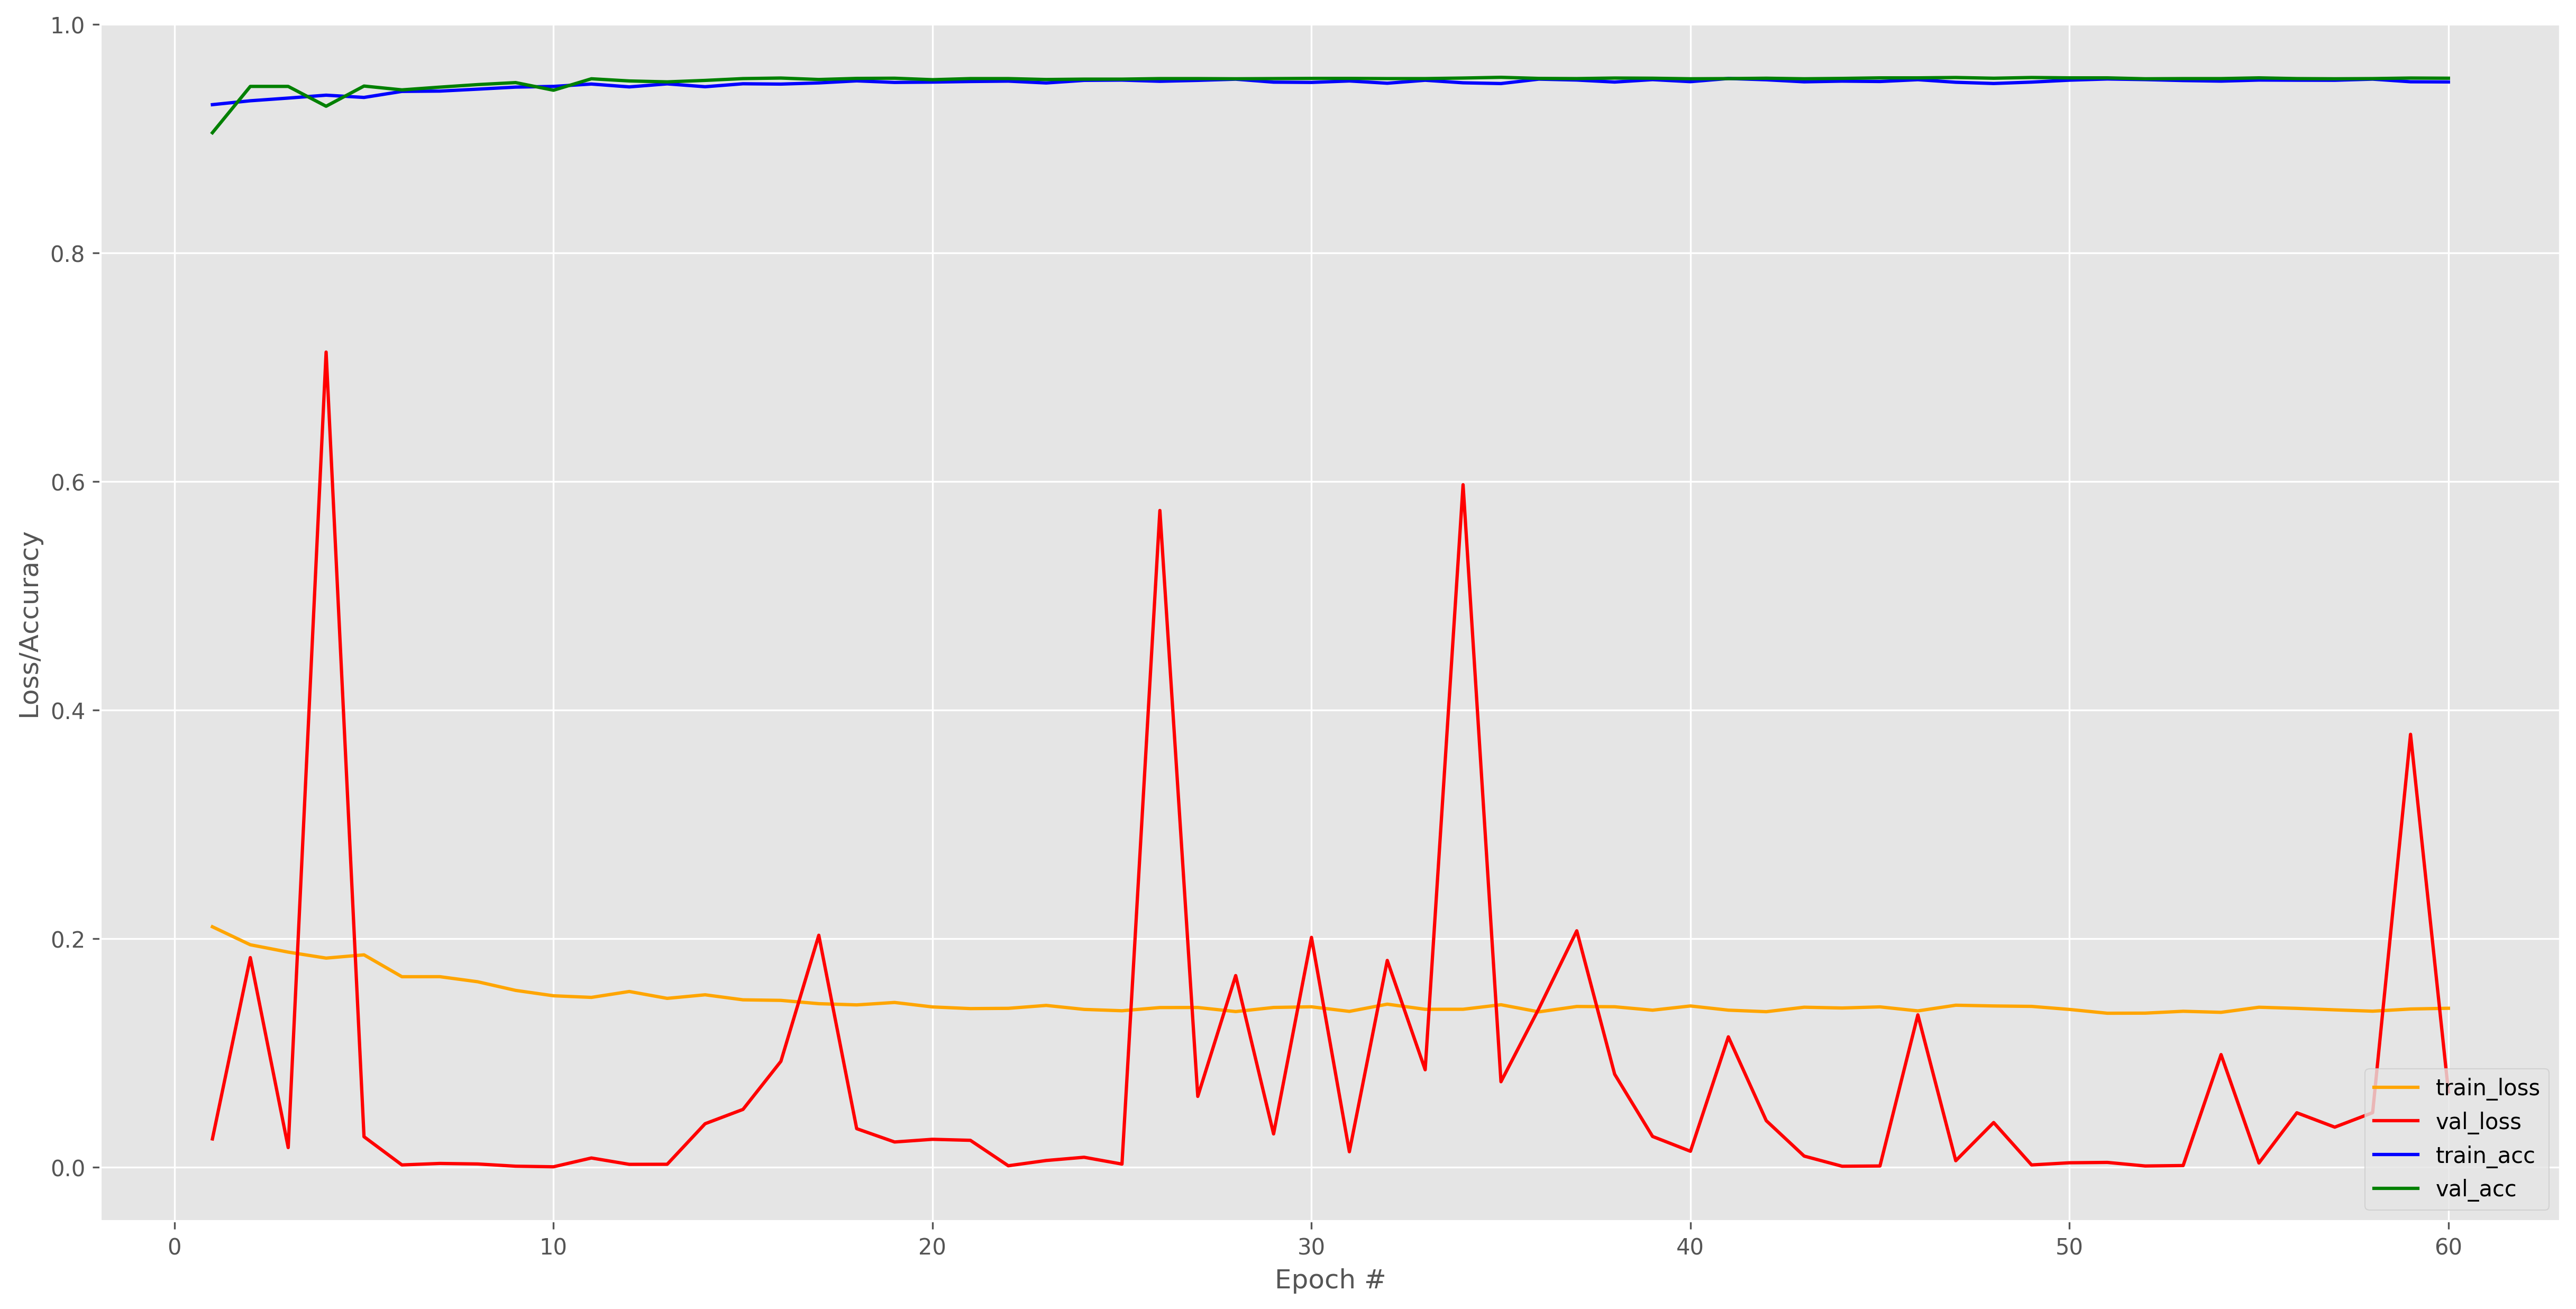

In [23]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("custom_plot.png")

In [24]:
#%% compile and train the VGG19 model

adam = Adam(lr=0.0001)
vgg19_custom_model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy']) 
filepath = 'weights/' + vgg19_custom_model.name + '.{epoch:02d}-{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_weights_only=False, save_best_only=True, mode='min', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                              verbose=1, min_lr=0.00001)

#tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, reduce_lr]
history = vgg19_custom_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    


Epoch 1/60
1328/1328 [==============================] - 135s 102ms/step - loss: 0.2668 - accuracy: 0.8905 - val_loss: 0.1044 - val_accuracy: 0.9434
Epoch 2/60
   2/1328 [..............................] - ETA: 2:02 - loss: 0.2794 - accuracy: 0.9062

/home/kaustubh/Work/common/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1328/1328 [==============================] - 131s 98ms/step - loss: 0.2051 - accuracy: 0.9305 - val_loss: 0.3336 - val_accuracy: 0.9478
Epoch 3/60
1328/1328 [==============================] - 130s 98ms/step - loss: 0.1912 - accuracy: 0.9345 - val_loss: 0.0331 - val_accuracy: 0.9499
Epoch 4/60
1328/1328 [==============================] - 129s 97ms/step - loss: 0.1852 - accuracy: 0.9351 - val_loss: 0.9280 - val_accuracy: 0.9473
Epoch 5/60
1328/1328 [==============================] - 130s 98ms/step - loss: 0.1723 - accuracy: 0.9396 - val_loss: 0.0661 - val_accuracy: 0.9526

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/60
1328/1328 [==============================] - 130s 98ms/step - loss: 0.1580 - accuracy: 0.9440 - val_loss: 0.0103 - val_accuracy: 0.9545
Epoch 7/60
1328/1328 [==============================] - 131s 98ms/step - loss: 0.1540 - accuracy: 0.9450 - val_loss: 0.0145 - val_accuracy: 0.9494
Epoch 8/60
1328/1328 [==========================

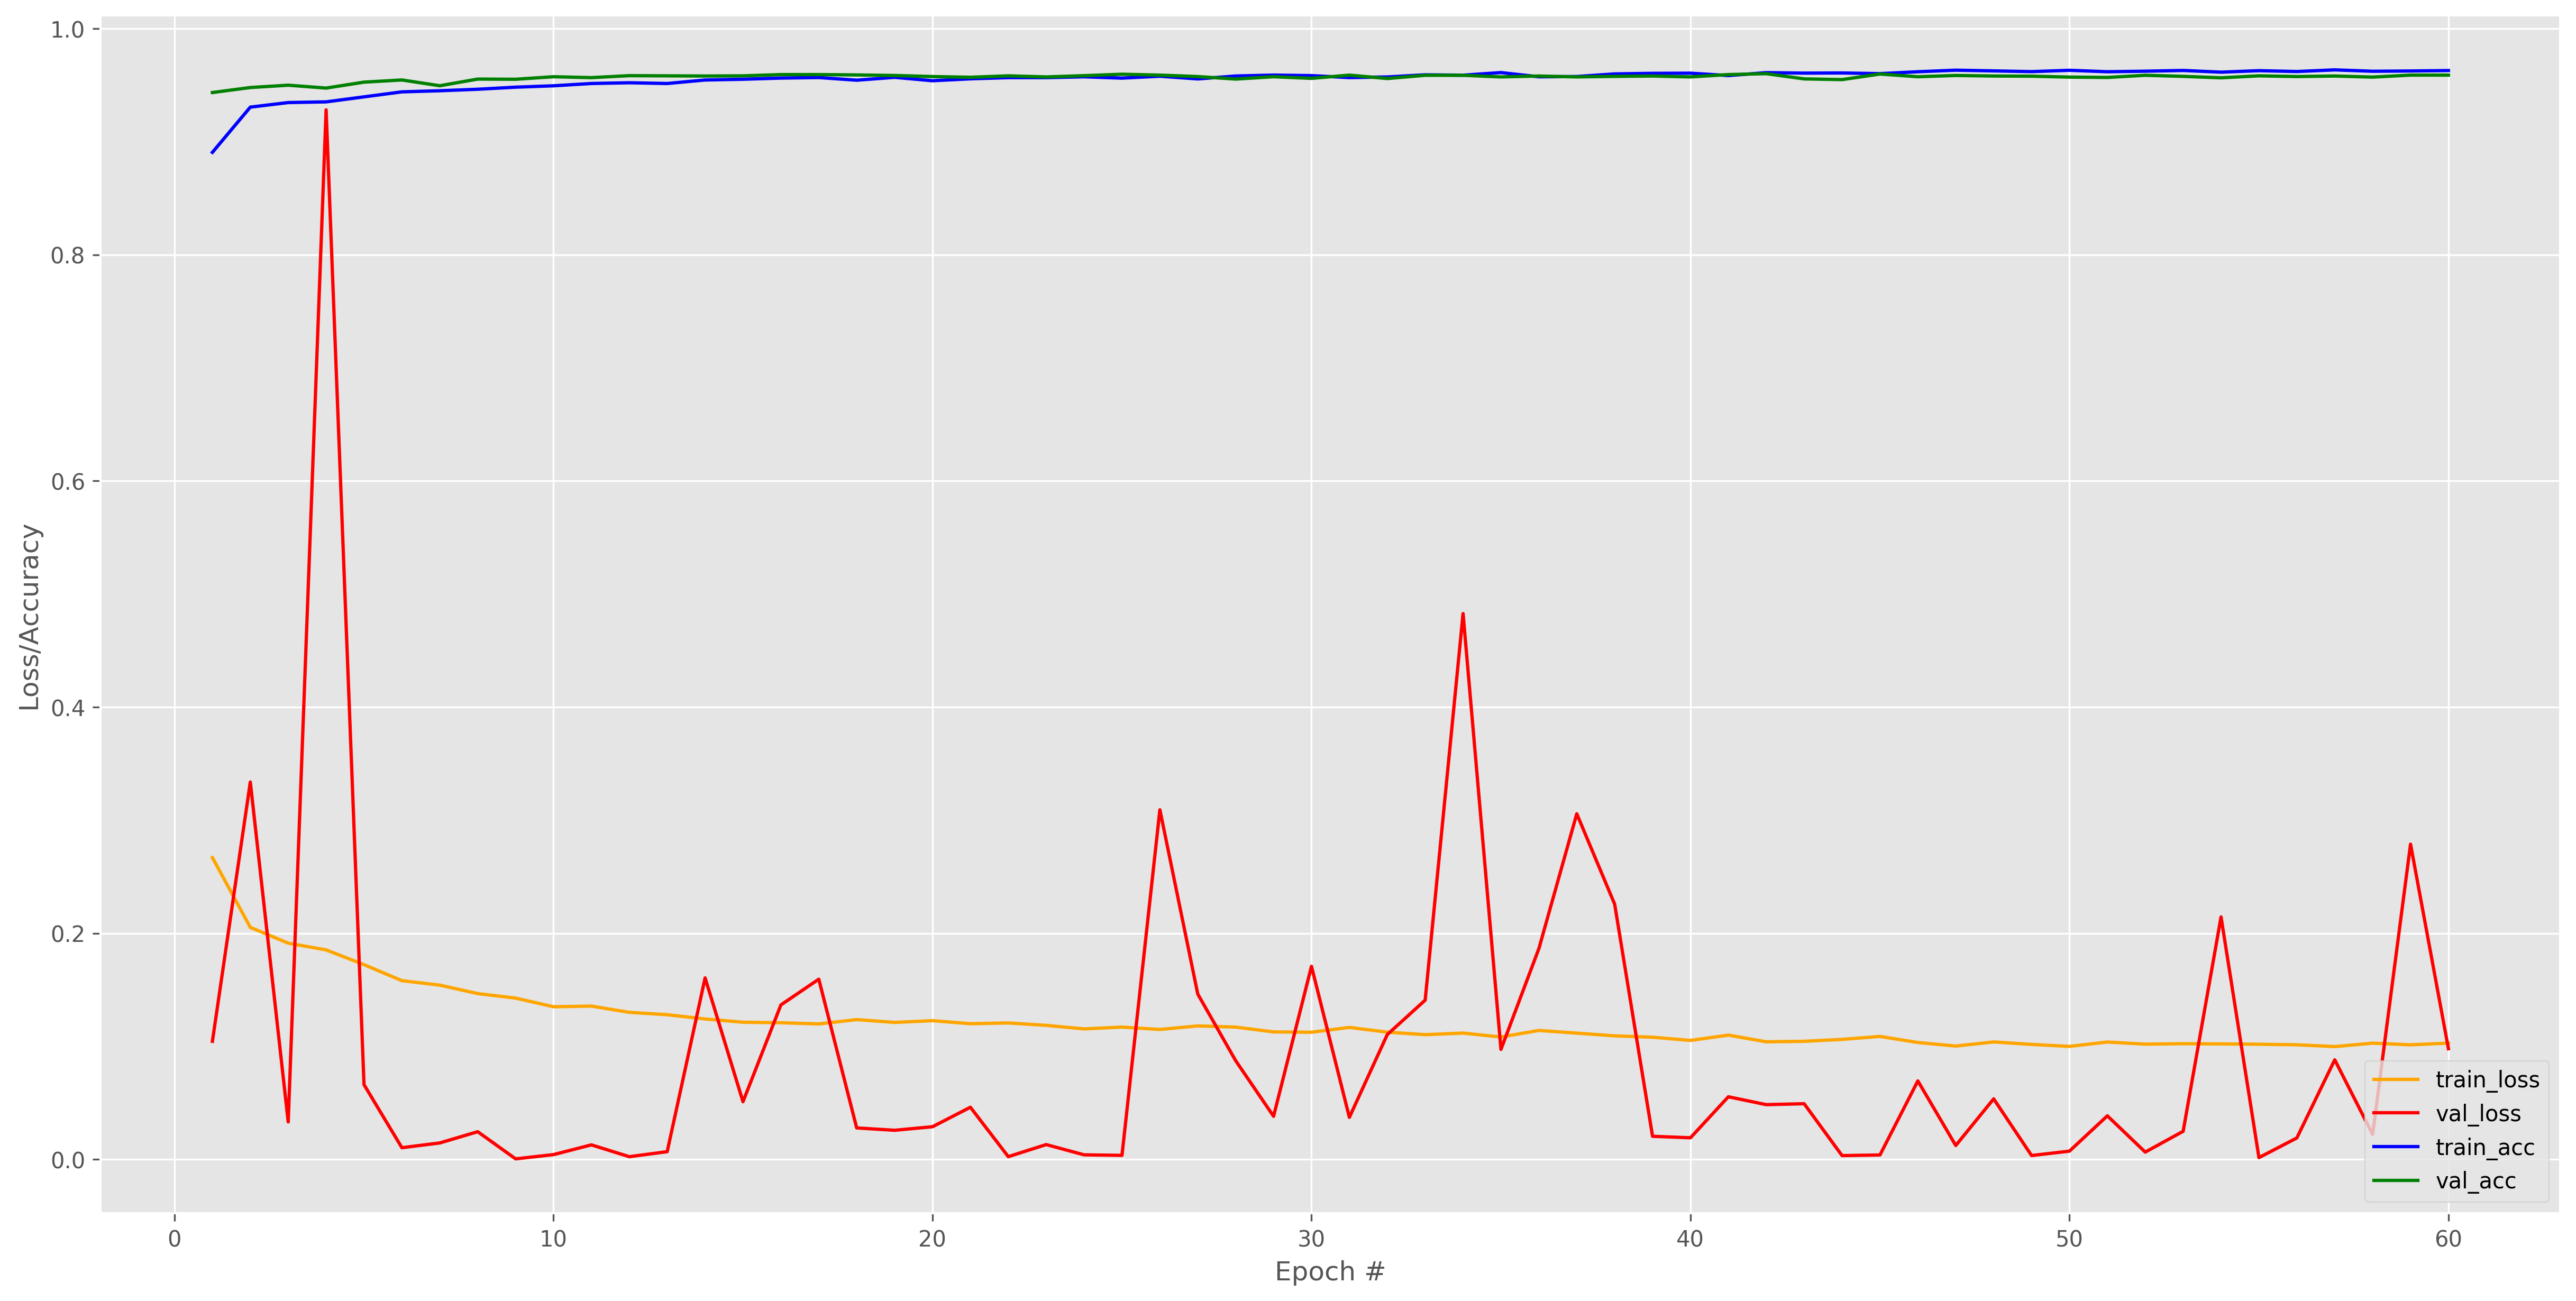

In [25]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("VGG19_custom_plot.png")

In [30]:
#%% compile and train the squeezenet model

adam = Adam(lr=0.0001) 
squeeze_custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
filepath = 'weights/' + squeeze_custom_model.name + '.{epoch:02d}-{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_weights_only=False, save_best_only=True, mode='min', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                              verbose=1, min_lr=0.00001)

#tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, reduce_lr]
history = squeeze_custom_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

Epoch 1/60
1328/1328 [==============================] - 60s 45ms/step - loss: 0.1749 - accuracy: 0.9367 - val_loss: 0.1260 - val_accuracy: 0.9517

Epoch 00001: val_loss improved from inf to 0.12603, saving model to weights/squeeze_custom.01-0.1260.h5
Epoch 2/60
1328/1328 [==============================] - 61s 46ms/step - loss: 0.1671 - accuracy: 0.9397 - val_loss: 0.2954 - val_accuracy: 0.9526

Epoch 00002: val_loss did not improve from 0.12603
Epoch 3/60
1328/1328 [==============================] - 59s 45ms/step - loss: 0.1631 - accuracy: 0.9391 - val_loss: 0.1116 - val_accuracy: 0.9502

Epoch 00003: val_loss improved from 0.12603 to 0.11159, saving model to weights/squeeze_custom.03-0.1116.h5
Epoch 4/60
1328/1328 [==============================] - 58s 43ms/step - loss: 0.1561 - accuracy: 0.9422 - val_loss: 0.5613 - val_accuracy: 0.9543

Epoch 00004: val_loss did not improve from 0.11159
Epoch 5/60
1328/1328 [==============================] - 59s 44ms/step - loss: 0.1549 - accuracy: 0

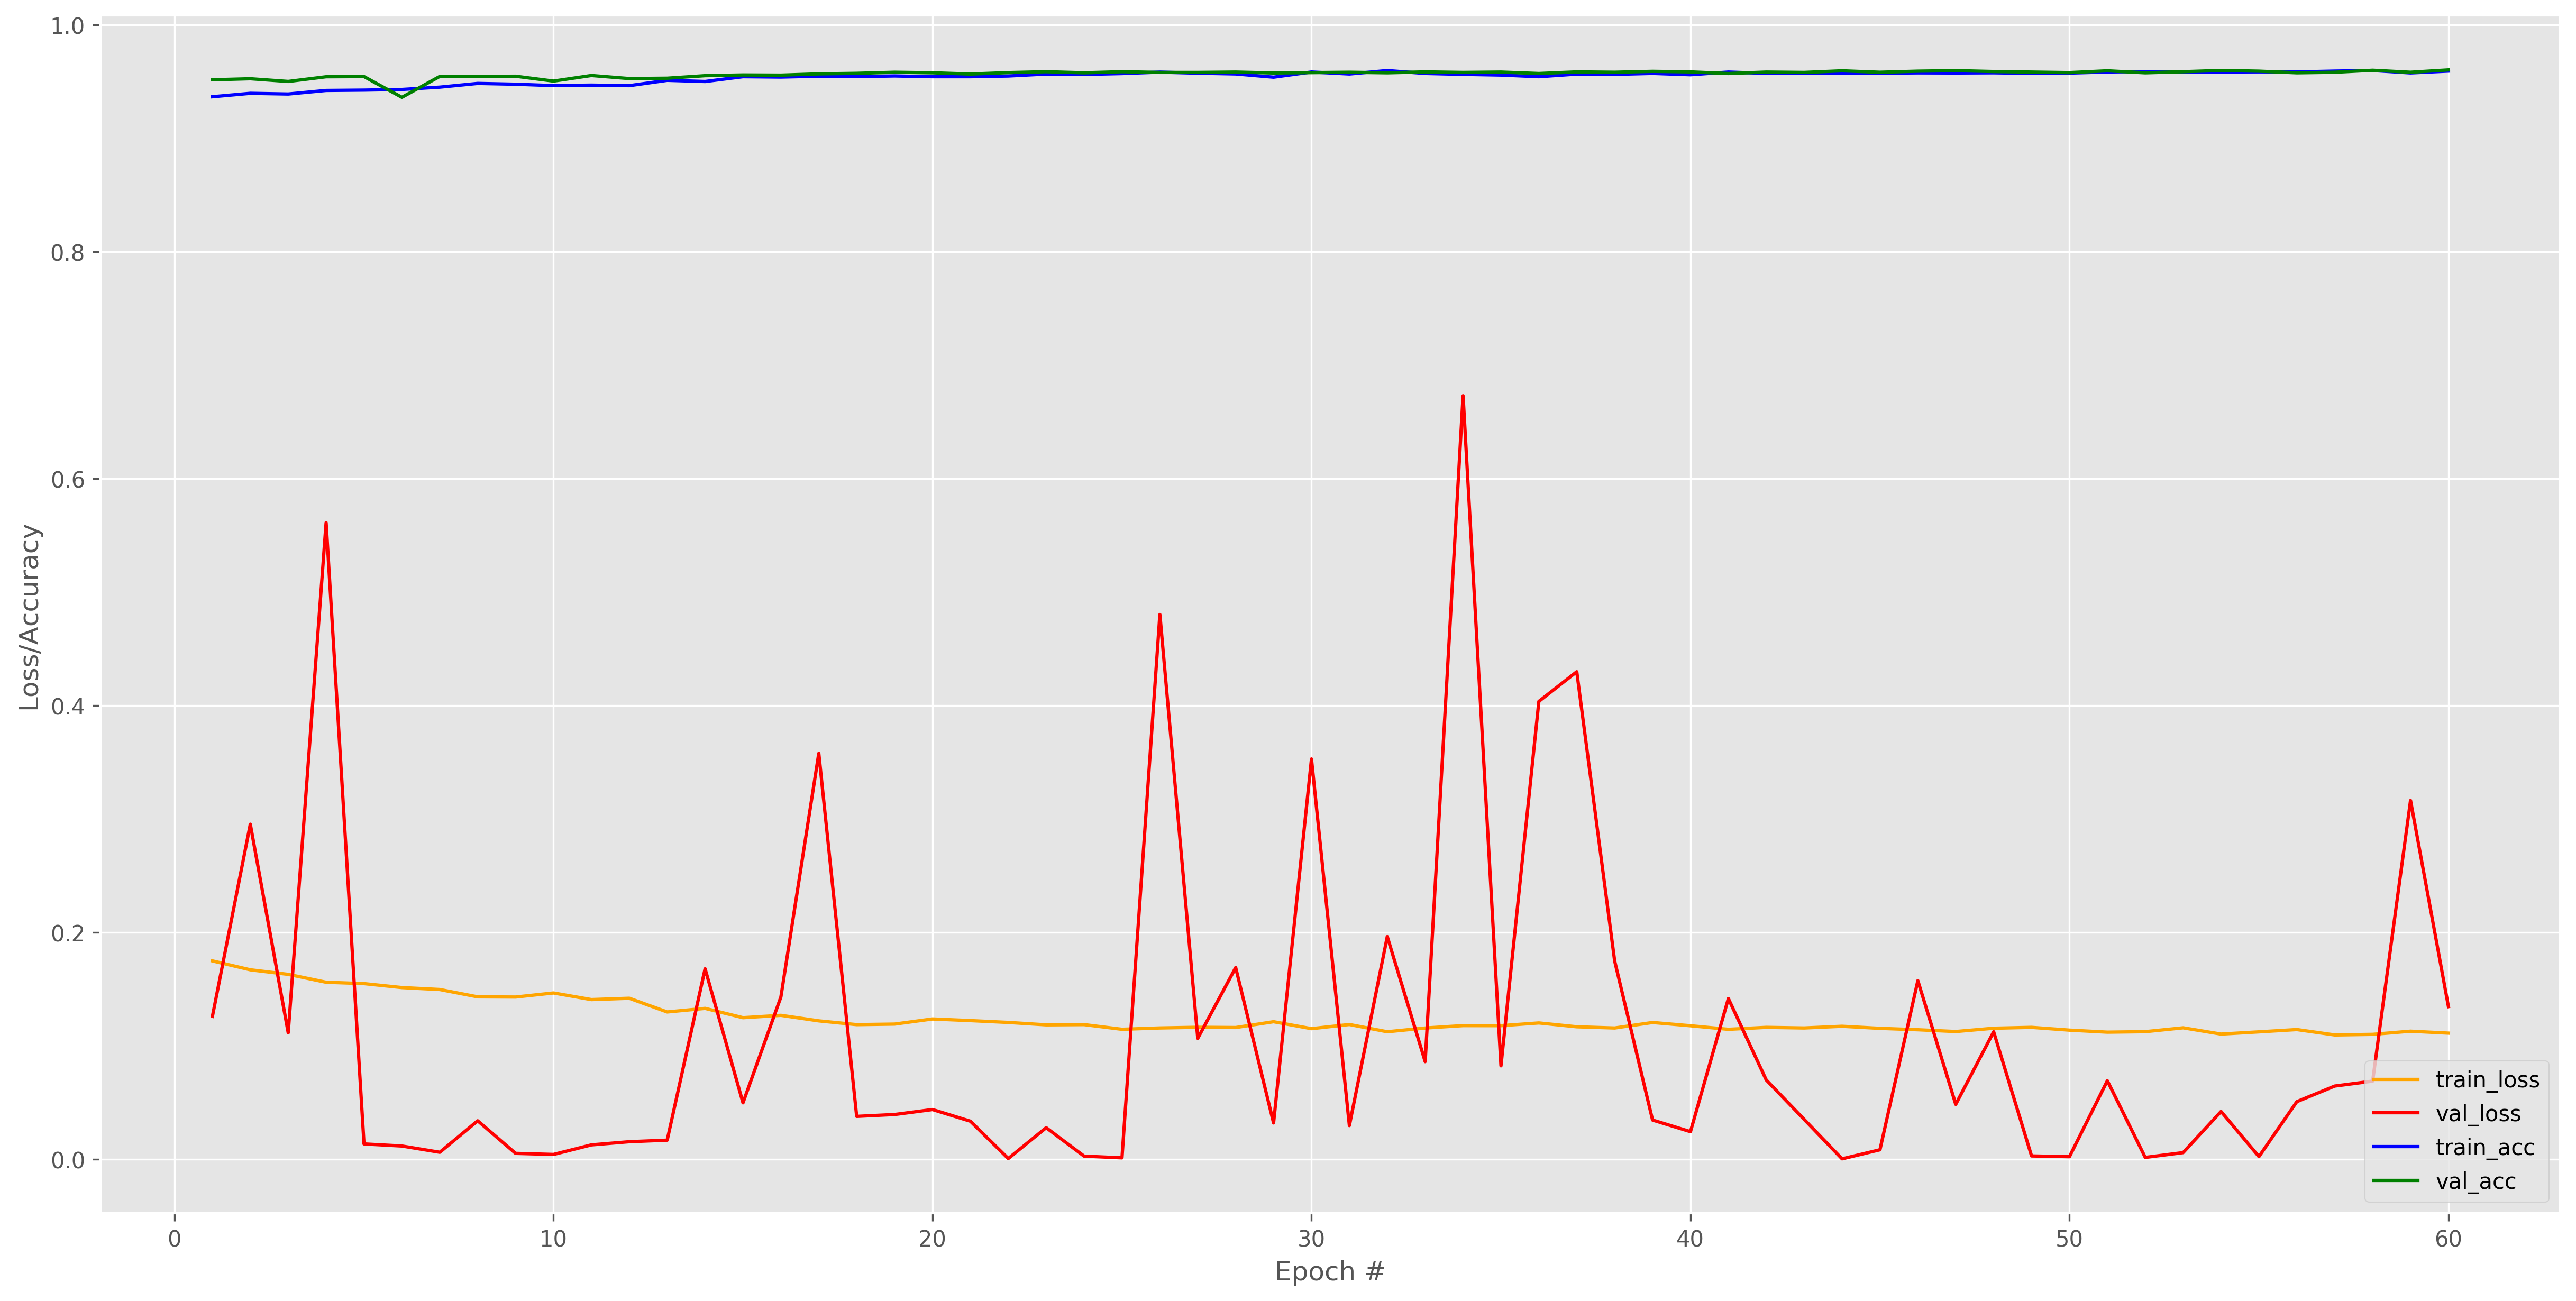

In [31]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("SqueezeNet_custom_plot.png")

In [ ]:
#%% compile and train the InceptionResnetV2 model

adam = Adam(lr=0.0001)  
inceptionresnet_custom_model.compile(optimizer=adam,
                                     loss='categorical_crossentropy', metrics=['accuracy']) 
filepath = 'weights/' + inceptionresnet_custom_model.name + '.{epoch:02d}-{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_weights_only=False, save_best_only=True, mode='min', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                              verbose=1, mode='min', min_lr=0.00001)

#tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, reduce_lr]
history = inceptionresnet_custom_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)    

In [ ]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["acc"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), history.history["val_acc"], 'green', label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("InceptionResnet_custom_plot.png")

In [ ]:
#Evaluate the model by loading the best weights
custom_model.load_weights('weights/custom_cnn.15-0.9919.h5')

#evaluate accuracy
custom_y_pred = custom_model.predict_generator(validation_generator,
                                               nb_validation_samples/batch_size, workers=1)
accuracy = accuracy_score(Y_test,custom_y_pred.argmax(axis=-1))
print('The accuracy of the Custom model is: ', accuracy)

#evaluate mean squared error
custom_mse = mean_squared_error(Y_test,custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Custom model is: ', custom_mse)

#evaluate mean squared log error
custom_msle = mean_squared_log_error(Y_test,custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Custom model is: ', custom_msle)

In [ ]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


In [ ]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for Custom model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Evaluate the model by loading the best weights 
vgg19_custom_model.load_weights('weights/vgg19_custom.45-0.9963.h5')

#evaluate accuracy
vgg19_custom_y_pred = vgg19_custom_model.predict_generator(validation_generator,
                                                           nb_validation_samples/batch_size, workers=1)
vgg19_accuracy = accuracy_score(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The accuracy of the VGG19 Custom model is: ', vgg19_accuracy)

#evaluate mean squared error
vgg19_custom_mse = mean_squared_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the VGG19 Custom model is: ', vgg19_custom_mse)

#evaluate mean squared log error
vgg19_custom_msle = mean_squared_log_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the VGG19 Custom model is: ', vgg19_custom_msle)

In [ ]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,vgg19_custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


In [ ]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, vgg19_custom_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for VGG19 Custom model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#Evaluate the model by loading the best weights 
squeeze_custom_model.load_weights('weights/squeeze_custom.11-0.9948.h5')

#evaluate accuracy

squeeze_y_pred = squeeze_custom_model.predict_generator(validation_generator,
                                                        nb_validation_samples/batch_size, workers=1)
squeeze_accuracy = accuracy_score(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The accuracy of the SqueezeNet Custom model is: ', squeeze_accuracy)

#evaluate mean squared error

squeeze_custom_mse = mean_squared_error(Y_test,squeeze_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the SqueezeNet Custom model is: ', squeeze_custom_mse)

#evaluate mean squared log error

squeeze_custom_msle = mean_squared_log_error(Y_test,squeeze_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the SqueezeNet Custom model is: ', squeeze_custom_msle)

In [ ]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,squeeze_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,squeeze_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


In [ ]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, squeeze_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for SqueezeNet Custom model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#Evaluate the model by loading the best weights 
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.15-0.9956.h5')

#evaluate accuracy
incepres_y_pred = inceptionresnet_custom_model.predict_generator(validation_generator,
                                                                 nb_validation_samples/batch_size, workers=1)
incepres_accuracy = accuracy_score(Y_test,incepres_y_pred.argmax(axis=-1))
print('The accuracy of the InceptionResNetV2 Custom model is: ', incepres_accuracy)

#evaluate mean squared error
incepres_custom_mse = mean_squared_error(Y_test,incepres_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the InceptionResNetv2 Custom model is: ', incepres_custom_mse)

#evaluate mean squared log error
incepres_custom_msle = mean_squared_log_error(Y_test,incepres_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the InceptionResNetv2 Custom model is: ', incepres_custom_msle)

In [ ]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,incepres_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,incepres_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


In [ ]:
#%% compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, incepres_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for InceptionResNetV2 Custom model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#%% construct the ensemble model
custom_model = custom_cnn(model_input)
vgg19_custom_model = vgg19_cnn(model_input)
squeeze_custom_model = squeeze_cnn(model_input)
inceptionresnet_custom_model = incepres_cnn(model_input)

#load the best weights
custom_model.load_weights('weights/custom_cnn.15-0.9919.h5')
vgg19_custom_model.load_weights('weights/vgg19_custom.45-0.9963.h5')
squeeze_custom_model.load_weights('weights/squeeze_custom.11-0.9948.h5')
inceptionresnet_custom_model.load_weights('weights/InceptionResnet_custom.15-0.9956.h5')

In [ ]:
#%% modify squeezenet layer name to avoid common names while forming ensemble

squeeze_custom_model.get_layer(name='conv1').name='conv1SQUEEZE'

In [ ]:
#append the models to the list

models = [custom_model, vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

Ensemble model definition is very straightforward. It uses the same input layer thas is shared between all previous models. 
In the top layer, the ensemble computes the average of three models' outputs (predictions) by using Average() layer. The ensemble is expected to have a lower error rate than any single model and better accuracy.

In [ ]:
def ensemble(models, model_input):
    
    outputs = [m.output for m in models]
    print(outputs)
    y = Average()(outputs) 
    model = Model(model_input, y, name='ensemble')
    return model

#istantitate the ensemble model and report the summary
ensemble_model = ensemble(models,model_input)

#save the ensemble model with the architecture and the weights together
ensemble_model.save('weights/ensemblemodel.h5')
print('The Ensemble Model is Saved')

In [ ]:
#%% load the ensemble model and make predictions on the test data
ensemble_model=load_model('weights/ensemblemodel.h5')
ensemble_model.summary()
plot_model(ensemble_model, to_file='ensemble_model.png',show_shapes=True, show_layer_names=False)

In [ ]:
#evaluate accuracy
ensem_y_pred = ensemble_model.predict_generator(validation_generator,
                                                nb_validation_samples/batch_size, workers=1)
ensemble_model_accuracy = accuracy_score(Y_test,ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Ensemble model is: ', ensemble_model_accuracy)

#evaluate mean squared error
ensemble_model_custom_mse = mean_squared_error(Y_test,ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Ensemble model is: ', ensemble_model_custom_mse)

#evaluate mean squared log error
ensemble_model_custom_msle = mean_squared_log_error(Y_test,ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Ensemble model is: ', ensemble_model_custom_msle)

In [ ]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


In [ ]:
#%% compute the ROC-AUC values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics for the Ensemble model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#%% Other Possible Ensembles: 
# We can select the optimal ensemble from the collection of model combinations

pair_A = [custom_model, vgg19_custom_model]
pair_B = [custom_model, squeeze_custom_model]
pair_C = [custom_model, inceptionresnet_custom_model]
pair_D = [vgg19_custom_model, squeeze_custom_model]
pair_E = [vgg19_custom_model, inceptionresnet_custom_model]
pair_F = [squeeze_custom_model, inceptionresnet_custom_model]
pair_G = [custom_model, vgg19_custom_model, squeeze_custom_model]
pair_H = [custom_model, vgg19_custom_model, inceptionresnet_custom_model]
pair_I = [vgg19_custom_model, squeeze_custom_model, inceptionresnet_custom_model]

In [ ]:
#%% evaluate the performance of these paired ensembles

pair_A_ensemble_model = ensemble(pair_A, model_input)
pair_A_ensemble_model.save('weights/ensemblemodel_pairA.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
A_ensem_y_pred = pair_A_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
A_ensemble_model_accuracy = accuracy_score(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair A Ensemble model is: ', A_ensemble_model_accuracy)

#evaluate mean squared error
A_ensemble_model_custom_mse = mean_squared_error(Y_test,A_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_mse)

#evaluate mean squared log error
A_ensemble_model_custom_msle = mean_squared_log_error(Y_test,A_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair A Ensemble model is: ', A_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,A_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,A_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, A_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#%% Pair B 

pair_B_ensemble_model = ensemble(pair_B, model_input)
pair_B_ensemble_model.save('weights/ensemblemodel_pairB.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
B_ensem_y_pred = pair_B_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
B_ensemble_model_accuracy = accuracy_score(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair B Ensemble model is: ', B_ensemble_model_accuracy)

#evaluate mean squared error
B_ensemble_model_custom_mse = mean_squared_error(Y_test,B_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_mse)

#evaluate mean squared log error
B_ensemble_model_custom_msle = mean_squared_log_error(Y_test,B_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair B Ensemble model is: ', B_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test,B_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,B_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, B_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#%% Pair C

pair_C_ensemble_model = ensemble(pair_C, model_input)
pair_C_ensemble_model.save('weights/ensemblemodel_pairC.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
C_ensem_y_pred = pair_C_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
C_ensemble_model_accuracy = accuracy_score(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair C Ensemble model is: ', C_ensemble_model_accuracy)

#evaluate mean squared error
C_ensemble_model_custom_mse = mean_squared_error(Y_test,C_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_mse)

#evaluate mean squared log error
C_ensemble_model_custom_msle = mean_squared_log_error(Y_test,C_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair C Ensemble model is: ', C_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,C_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,C_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names)

plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, C_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#%% Pair D

pair_D_ensemble_model = ensemble(pair_D, model_input)
pair_D_ensemble_model.save('weights/ensemblemodel_pairD.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
D_ensem_y_pred = pair_D_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
D_ensemble_model_accuracy = accuracy_score(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair D_ Ensemble model is: ', D_ensemble_model_accuracy)

#evaluate mean squared error
D_ensemble_model_custom_mse = mean_squared_error(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_mse)

#evaluate mean squared log error
D_ensemble_model_custom_msle = mean_squared_log_error(Y_test,D_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,D_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,D_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, A_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


In [ ]:
 #%% Pair E

pair_E_ensemble_model = ensemble(pair_E, model_input)
pair_E_ensemble_model.save('weights/ensemblemodel_pairE.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
E_ensem_y_pred = pair_E_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
E_ensemble_model_accuracy = accuracy_score(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair E_ Ensemble model is: ', E_ensemble_model_accuracy)

#evaluate mean squared error
E_ensemble_model_custom_mse = mean_squared_error(Y_test,E_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_mse)

#evaluate mean squared log error
E_ensemble_model_custom_msle = mean_squared_log_error(Y_test,E_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair E Ensemble model is: ', E_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,E_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, E_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
 #%% Pair F

pair_F_ensemble_model = ensemble(pair_F, model_input)
pair_F_ensemble_model.save('weights/ensemblemodel_pairF.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
F_ensem_y_pred = pair_F_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
F_ensemble_model_accuracy = accuracy_score(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair F_ Ensemble model is: ', F_ensemble_model_accuracy)

#evaluate mean squared error
F_ensemble_model_custom_mse = mean_squared_error(Y_test,F_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair F_ Ensemble model is: ', F_ensemble_model_custom_mse)

#evaluate mean squared log error
F_ensemble_model_custom_msle = mean_squared_log_error(Y_test,F_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair F_Ensemble model is: ', F_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,F_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,F_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, F_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
 #%% Pair G

pair_G_ensemble_model = ensemble(pair_G, model_input)
pair_G_ensemble_model.save('weights/ensemblemodel_pairG.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
G_ensem_y_pred = pair_G_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
G_ensemble_model_accuracy = accuracy_score(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair G_ Ensemble model is: ', G_ensemble_model_accuracy)

#evaluate mean squared error
G_ensemble_model_custom_mse = mean_squared_error(Y_test,G_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_mse)

#evaluate mean squared log error
G_ensemble_model_custom_msle = mean_squared_log_error(Y_test,G_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair G_ Ensemble model is: ', G_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,G_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, G_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#%% Pair H

pair_H_ensemble_model = ensemble(pair_H, model_input)
pair_H_ensemble_model.save('weights/ensemblemodel_pairH.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
H_ensem_y_pred = pair_H_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
H_ensemble_model_accuracy = accuracy_score(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair H_ Ensemble model is: ', H_ensemble_model_accuracy)

#evaluate mean squared error
H_ensemble_model_custom_mse = mean_squared_error(Y_test,H_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_mse)

#evaluate mean squared log error
H_ensemble_model_custom_msle = mean_squared_log_error(Y_test,H_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair H_ Ensemble model is: ', H_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,E_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,H_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, H_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#%% Pair I

pair_I_ensemble_model = ensemble(pair_I, model_input)
pair_I_ensemble_model.save('weights/ensemblemodel_pairI.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
I_ensem_y_pred = pair_I_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
I_ensemble_model_accuracy = accuracy_score(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair I_ Ensemble model is: ', I_ensemble_model_accuracy)

#evaluate mean squared error
I_ensemble_model_custom_mse = mean_squared_error(Y_test,I_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_mse)

#evaluate mean squared log error
I_ensemble_model_custom_msle = mean_squared_log_error(Y_test,I_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair I_ Ensemble model is: ', I_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,I_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,I_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, I_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(20,10), dpi=300)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()